In [106]:
## Importing Important Libraries ##
import numpy as np
import pandas as pd
pd.set_option('max_columns', None)

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, precision_score, recall_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import LinearSVC, SVC
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
import warnings
warnings.filterwarnings('ignore')

In [3]:
##Lets Check what type of data we have##
df = pd.read_csv('WA_Fn-UseC_-HR-Employee-Attrition.csv')
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


In [9]:
##Lets check null values and the type of columns we have##
df.isnull().sum().sum(),df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

(0, None)

##### So it does look like we have no null data and it does look like we have most of our column in numbers so that should be good for using our models however some we do need to create dummies for.

### Quick Plots to get some info

In [31]:
df['Attrition2'] = df.Attrition.replace({'Yes': 1,'No':0})

In [36]:
df.groupby(by = 'Department').Attrition2.mean()

Department
Human Resources           0.190476
Research & Development    0.138398
Sales                     0.206278
Name: Attrition2, dtype: float64

<AxesSubplot:>

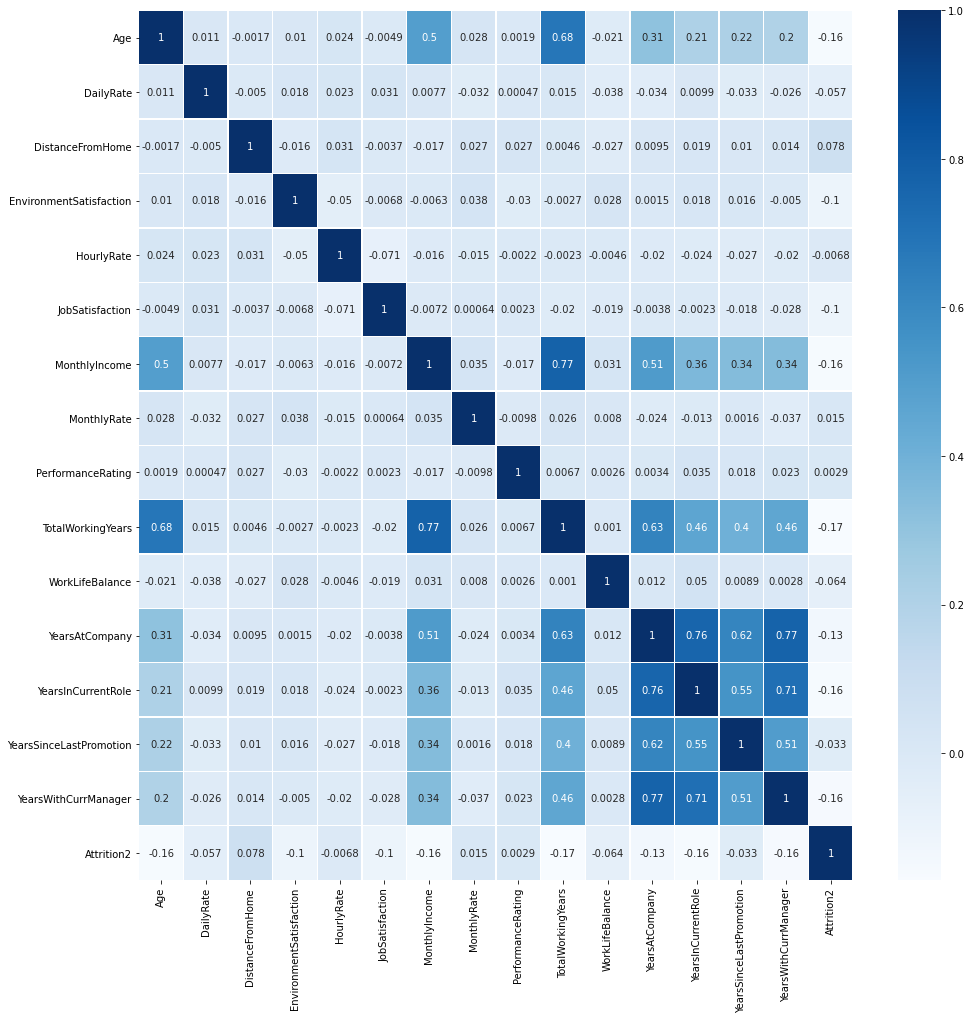

In [47]:
df_corr = df.drop(columns = ['StandardHours','Education','EmployeeCount','EmployeeNumber','JobInvolvement','JobLevel','NumCompaniesWorked','PercentSalaryHike','RelationshipSatisfaction','StockOptionLevel','TrainingTimesLastYear'])
plt.figure(figsize=(16, 16))
sns.heatmap(df_corr.corr(),linewidths=.3,annot=True,cmap='Blues')

### we cant find much correlation between the attrition and the other columns so i guess we can move on with the model training

In [48]:
def onehot_encode(df, column):
    df = df.copy()
    dummies = pd.get_dummies(df[column], prefix=column)
    df = pd.concat([df, dummies], axis=1)
    df = df.drop(column, axis=1)
    return df

In [68]:
def preprocess_inputs(df):
    df = df.copy()
    
    # Drop single-value columns and id columns
    df = df.drop(['EmployeeCount', 'EmployeeNumber', 'Over18', 'StandardHours'], axis=1)
    
    # Binary-encode binary columns
    df['Gender'] = df['Gender'].replace({'Female': 0, 'Male': 1})
    df['OverTime'] = df['OverTime'].replace({'No': 0, 'Yes': 1})
    
    # Ordinal-encode the BusinessTravel column
    df['BusinessTravel'] = df['BusinessTravel'].replace({'Non-Travel': 0, 'Travel_Rarely': 1, 'Travel_Frequently': 2})
    
    # One-hot encoding
    for column in ['Department', 'EducationField', 'JobRole', 'MaritalStatus']:
        df = onehot_encode(df, column=column)
    
    # Split df into X and y
    y = df['Attrition'].replace({'Yes':1,'No':0})
    X = df.drop('Attrition', axis=1)
    
    # Train-test split
    X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.5, random_state=42)
    
    # Scale X
    scaler = StandardScaler()
    scaler.fit(X_train)
    X_train = pd.DataFrame(scaler.transform(X_train), index=X_train.index, columns=X_train.columns)
    X_test = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)
    
    return X_train, X_test, y_train, y_test

In [69]:
X_train, X_test, y_train, y_test = preprocess_inputs(df)
X_train

,Age,BusinessTravel,DailyRate,DistanceFromHome,Education,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition2,Department_Human Resources,Department_Research & Development,Department_Sales,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
1058,-0.282351,-0.160600,-0.001994,1.796962,1.041161,-1.544434,-1.217829,-1.340409,-1.075066,0.009729,-0.669857,-0.350559,-0.906642,-1.043345,1.570663,2.188960,2.396481,0.283727,-0.944858,0.650276,-0.597646,1.765809,1.353817,1.405472,2.686433,1.718047,2.127514,-0.202673,-1.397071,1.530003,-0.117444,-0.809571,-0.359211,1.481773,-0.275925,-0.319295,-0.292698,-0.183726,-0.489347,-0.273059,-0.306186,-0.239904,-0.519067,1.983151,-0.275925,-0.538028,-0.912643,1.454100
71,-0.819153,-0.160600,1.314182,-0.924739,0.090536,0.279115,0.821133,0.434905,0.388218,-0.884133,-0.669857,-0.748359,-1.312374,-1.043345,-0.636674,2.188960,2.396481,1.223093,0.184362,-0.613481,0.185366,0.339579,-0.289816,-0.010791,-0.677329,0.017354,-0.470032,-0.202673,0.715783,-0.653594,-0.117444,1.235222,-0.359211,-0.674867,-0.275925,-0.319295,-0.292698,-0.183726,-0.489347,-0.273059,-0.306186,-0.239904,1.926535,-0.504248,-0.275925,-0.538028,1.095718,-0.687711
94,-0.497072,-0.160600,0.739273,-0.429884,1.041161,-0.632660,0.821133,0.977362,0.388218,0.009729,0.248697,-0.264327,1.432952,-0.641638,-0.636674,0.243176,-0.417279,-1.595006,-0.944858,0.144773,-2.163672,0.339579,0.696364,1.122220,1.004552,0.867701,-0.470032,-0.202673,-1.397071,1.530003,-0.117444,-0.809571,-0.359211,1.481773,-0.275925,-0.319295,-0.292698,-0.183726,-0.489347,-0.273059,-0.306186,-0.239904,-0.519067,1.983151,-0.275925,-0.538028,-0.912643,1.454100
810,1.005975,-0.160600,-0.941420,-0.801025,-1.810715,-1.544434,0.821133,-0.748638,0.388218,1.797452,0.248697,2.348862,0.197591,0.161776,-0.636674,-0.868701,-0.417279,1.223093,0.184362,1.534906,0.185366,0.339579,0.860727,1.405472,0.668176,1.434599,-0.470032,-0.202673,-1.397071,1.530003,-0.117444,-0.809571,2.783882,-0.674867,-0.275925,-0.319295,-0.292698,-0.183726,-0.489347,3.662208,-0.306186,-0.239904,-0.519067,-0.504248,-0.275925,-0.538028,1.095718,-0.687711
33,0.254452,-0.160600,0.254881,-0.553598,0.090536,1.190889,0.821133,-0.551381,0.388218,0.009729,1.167250,-0.877812,-1.542416,0.161776,-0.636674,-0.312763,-0.417279,0.283727,0.184362,1.029403,2.534404,1.765809,-0.947269,-1.143801,-0.677329,-1.116442,2.127514,-0.202673,-1.397071,1.530003,-0.117444,-0.809571,-0.359211,-0.674867,-0.275925,3.131904,-0.292698,-0.183726,-0.489347,-0.273059,-0.306186,-0.239904,-0.519067,-0.504248,3.624171,-0.538028,1.095718,-0.687711
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1130,-0.174990,-0.160600,-0.099851,2.291817,0.090536,-0.632660,0.821133,-1.044524,1.851503,0.009729,0.248697,-0.600653,1.581535,-0.641638,-0.636674,0.521145,-0.417279,1.223093,1.313583,-0.107978,0.185366,-1.086652,0.532000,1.405472,1.340928,1.151150,-0.470032,-0.202673,0.715783,-0.653594,-0.117444,1.235222,-0.359211,-0.674867,-0.275925,-0.319295,-0.292698,-0.183726,2.043540,-0.273059,-0.306186,-0.239904,-0.519067,-0.504248,-0.275925,-0.538028,1.095718,-0.687711
1294,0.469173,-0.160600,-0.841117,-0.553598,0.09053

In [70]:
models = {
    "                   Logistic Regression": LogisticRegression(),
    "                   K-Nearest Neighbors": KNeighborsClassifier(),
    "                         Decision Tree": DecisionTreeClassifier(),
    "Support Vector Machine (Linear Kernel)": LinearSVC(),
    "   Support Vector Machine (RBF Kernel)": SVC(),
    "                        Neural Network": MLPClassifier(),
    "                         Random Forest": RandomForestClassifier(),
    "                     Gradient Boosting": GradientBoostingClassifier()
}

for name, model in models.items():
    model.fit(X_train, y_train)
    print(name + " trained.")

                   Logistic Regression trained.
                   K-Nearest Neighbors trained.
                         Decision Tree trained.
Support Vector Machine (Linear Kernel) trained.
   Support Vector Machine (RBF Kernel) trained.
                        Neural Network trained.
                         Random Forest trained.
                     Gradient Boosting trained.


In [71]:
for name, model in models.items():
    print(name + ": {:.2f}%".format(model.score(X_test, y_test) * 100))

                   Logistic Regression: 100.00%
                   K-Nearest Neighbors: 90.20%
                         Decision Tree: 100.00%
Support Vector Machine (Linear Kernel): 100.00%
   Support Vector Machine (RBF Kernel): 99.59%
                        Neural Network: 99.05%
                         Random Forest: 100.00%
                     Gradient Boosting: 100.00%


#### Thanks to Gabriel Atkin (https://www.youtube.com/watch?v=5VP00gcgyo8) for his code for the test Right now i'll try something that i learned from Udacity Advanced data Analysis Course

In [72]:
df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition2
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,1
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,0
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,1
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,0


In [99]:
#create response and explanatory variables im gonna use specific columns
y = df['Attrition2']
df[['Non-Travel','Travel_Rarely','Travel_Frequently']] = pd.get_dummies(df['BusinessTravel'])
df[['Sales','Research & Development','Human Resources']] = pd.get_dummies(df['Department'])

X = df[['Age', 'Non-Travel','Travel_Rarely','Travel_Frequently','Sales','Research & Development','Human Resources','DistanceFromHome','EnvironmentSatisfaction','HourlyRate','JobSatisfaction','PerformanceRating']]

#create the train test split
X_train, X_test, y_train, y_test =train_test_split(X,y,test_size=0.30, random_state=42)


Precision Score 100.00%
recall_score 0.02%
accuracy_score 0.86%


array([[380,   0],
       [ 60,   1]], dtype=int64)

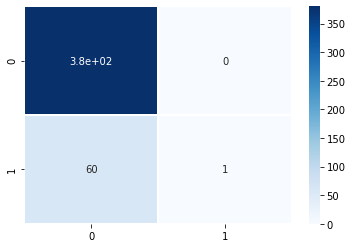

In [107]:
log_mod = LogisticRegression()

log_mod.fit(X_train, y_train)

y_preds = log_mod.predict(X_test)

print("Precision Score {:.2f}%".format(precision_score(y_test, y_preds)*100))
print("recall_score {:.2f}%".format(recall_score(y_test, y_preds)))
print("accuracy_score {:.2f}%".format(accuracy_score(y_test, y_preds)))
sns.heatmap(confusion_matrix(y_test, y_preds),linewidths=.3,annot=True,cmap='Blues')
confusion_matrix(y_test, y_preds)

In [140]:
y_pred_prob = log_mod.predict_proba(X_test)
y_pred_prob

array([[0.72355593, 0.27644407],
       [0.9301164 , 0.0698836 ],
       [0.7257836 , 0.2742164 ],
       [0.85557278, 0.14442722],
       [0.88952439, 0.11047561],
       [0.78985732, 0.21014268],
       [0.86862146, 0.13137854],
       [0.91615196, 0.08384804],
       [0.9756223 , 0.0243777 ],
       [0.9217409 , 0.0782591 ],
       [0.94659576, 0.05340424],
       [0.93061664, 0.06938336],
       [0.92742545, 0.07257455],
       [0.92025297, 0.07974703],
       [0.83974692, 0.16025308],
       [0.75200846, 0.24799154],
       [0.83169543, 0.16830457],
       [0.78614788, 0.21385212],
       [0.92067838, 0.07932162],
       [0.62931013, 0.37068987],
       [0.6347972 , 0.3652028 ],
       [0.92789818, 0.07210182],
       [0.87495307, 0.12504693],
       [0.66813846, 0.33186154],
       [0.59649106, 0.40350894],
       [0.92587702, 0.07412298],
       [0.79902436, 0.20097564],
       [0.63653137, 0.36346863],
       [0.89834173, 0.10165827],
       [0.85787161, 0.14212839],
       [0.

In [166]:
Age = 30
Non_Travel = 0
Travel_Rarely = 1
Travel_Frequently = 0
Sales = 0
Research_Development = 0
Human_Resources = 1
DistanceFromHome = 25
EnvironmentSatisfaction = 1
HourlyRate = 20
JobSatisfaction = 1
PerformanceRating = 1
Test = log_mod.predict([[Age,Non_Travel,Travel_Rarely,Travel_Frequently,Sales,Research_Development,Human_Resources,DistanceFromHome,EnvironmentSatisfaction,HourlyRate,JobSatisfaction,PerformanceRating]])
Test_conf = log_mod.predict_proba([[Age,Non_Travel,Travel_Rarely,Travel_Frequently,Sales,Research_Development,Human_Resources,DistanceFromHome,EnvironmentSatisfaction,HourlyRate,JobSatisfaction,PerformanceRating]])
ix = Test_conf.argmax(1).item()
print(f'predicted class = {[ix]} and confidence = {Test_conf[0,ix]:.2%}')

predicted class = [1] and confidence = 63.62%


### so with 86% Accuracy Logistic regression can be used to develop a quick app with The X_train as manual input to predict if an employee will leave or not will move the app to Spyder and will upload it with this rep 